# Tuning the Architecture
---
The layout of the layers and the overall model architecture was chosen quite arbirarily, in this notebook we will run some expermint with Ray-tune to see if we can come-up with a better architecture.

Before doing so, it might be interesting to mention some details about Ray, in this notebook a bunch of stuff has changed because of the way Ray works.

Ray is designed to optimize on multiple machines. So it has to be able to move contexts from one machine to the next. And it does so by serializing everything it finds in the **training_function**, (in this notebook, named `train_model`) using pickle. That is why it's quite common to having pickling mistakes executing this function.

The pickled data is sent to a `Ray Actor` (a separate process) which will execute and report back to the main optimizing function. This has a couple of implications.
- We do not want to be sending a lot of information (and there is a 100MB limit) to the actors. So it is best to have each of the actors read the file and build the numpy arrays itself. The reading needs to be done in the training function.
- Pickle does not like the Feature object. Not sure why, could be because they are data-classes. Therefore in order to get the `TensorDefinition` into Ray we will need to save them and re-load.
- The actors set-up a separate python process. This can be a bit tricky when we have `FeatureExpression` features. They want to function to be in the **main** module context. We'll have to pull a couple of tricks to achieve that (Some of which might feel a bit hacky)


## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
> pip install ray[tune]
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import marshal, types
import sys
import gc
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp
import m0d3l.raytune as rt

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import PopulationBasedTraining

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location. We made this an absolute path for **Ray**.

In [7]:
tr_train_file = '/home/toms/PycharmProjects/exp3r1m3nts/data/train_transaction.csv'

Define the features. In order for **Ray** to work we imported the required package with in the function. 

In [2]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
# The import of dt is needed to make Ray work. 
# If not imported here, the dt will not be available in the __main__ context
def offset_to_datetime(offset: int):
    import datetime as dt
    return dt.datetime(2017, 1, 11) + dt.timedelta(seconds=int(offset))

fraud     = ft.FeatureSource('isFraud', ft.FEATURE_TYPE_INT_8)
dtb       = ft.FeatureSource('TransactionDT', ft.FEATURE_TYPE_INT_32)
date_time = ft.FeatureExpression('date_time', ft.FEATURE_TYPE_DATE_TIME, offset_to_datetime, [dtb])

# Base Categorical features
amount  = ft.FeatureSource('TransactionAmt', ft.FEATURE_TYPE_FLOAT_32)
product = ft.FeatureSource('ProductCD', ft.FEATURE_TYPE_CATEGORICAL)
card1   = ft.FeatureSource('card1', ft.FEATURE_TYPE_CATEGORICAL)
card2   = ft.FeatureSource('card2', ft.FEATURE_TYPE_CATEGORICAL)
card3   = ft.FeatureSource('card3', ft.FEATURE_TYPE_CATEGORICAL)
card4   = ft.FeatureSource('card4', ft.FEATURE_TYPE_CATEGORICAL)
card5   = ft.FeatureSource('card5', ft.FEATURE_TYPE_CATEGORICAL)
card6   = ft.FeatureSource('card6', ft.FEATURE_TYPE_CATEGORICAL)
addr1   = ft.FeatureSource('addr1', ft.FEATURE_TYPE_CATEGORICAL)
addr2   = ft.FeatureSource('addr2', ft.FEATURE_TYPE_CATEGORICAL)
dist1   = ft.FeatureSource('dist1', ft.FEATURE_TYPE_FLOAT_32)
p_mail_dom = ft.FeatureSource('P_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)
r_mail_dom = ft.FeatureSource('R_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)

# Raw count features
c1  = ft.FeatureSource('C1', ft.FEATURE_TYPE_FLOAT_32)
c2  = ft.FeatureSource('C2', ft.FEATURE_TYPE_FLOAT_32)
c3  = ft.FeatureSource('C3', ft.FEATURE_TYPE_FLOAT_32)
c4  = ft.FeatureSource('C4', ft.FEATURE_TYPE_FLOAT_32)
c5  = ft.FeatureSource('C5', ft.FEATURE_TYPE_FLOAT_32)
c6  = ft.FeatureSource('C6', ft.FEATURE_TYPE_FLOAT_32)
c7  = ft.FeatureSource('C7', ft.FEATURE_TYPE_FLOAT_32)
c8  = ft.FeatureSource('C8', ft.FEATURE_TYPE_FLOAT_32)
c9  = ft.FeatureSource('C9', ft.FEATURE_TYPE_FLOAT_32)
c10 = ft.FeatureSource('C10', ft.FEATURE_TYPE_FLOAT_32)
c11 = ft.FeatureSource('C11', ft.FEATURE_TYPE_FLOAT_32)
c12 = ft.FeatureSource('C12', ft.FEATURE_TYPE_FLOAT_32)
c13 = ft.FeatureSource('C13', ft.FEATURE_TYPE_FLOAT_32)
c14 = ft.FeatureSource('C14', ft.FEATURE_TYPE_FLOAT_32)

# Raw distance features.
d1  = ft.FeatureSource('D1', ft.FEATURE_TYPE_FLOAT_32)
d2  = ft.FeatureSource('D2', ft.FEATURE_TYPE_FLOAT_32)
d3  = ft.FeatureSource('D3', ft.FEATURE_TYPE_FLOAT_32)
d4  = ft.FeatureSource('D4', ft.FEATURE_TYPE_FLOAT_32)
d5  = ft.FeatureSource('D5', ft.FEATURE_TYPE_FLOAT_32)
d6  = ft.FeatureSource('D6', ft.FEATURE_TYPE_FLOAT_32)
d7  = ft.FeatureSource('D7', ft.FEATURE_TYPE_FLOAT_32)
d8  = ft.FeatureSource('D8', ft.FEATURE_TYPE_FLOAT_32)
d9  = ft.FeatureSource('D9', ft.FEATURE_TYPE_FLOAT_32)
d10 = ft.FeatureSource('D10', ft.FEATURE_TYPE_FLOAT_32)
d11 = ft.FeatureSource('D11', ft.FEATURE_TYPE_FLOAT_32)
d12 = ft.FeatureSource('D12', ft.FEATURE_TYPE_FLOAT_32)
d13 = ft.FeatureSource('D13', ft.FEATURE_TYPE_FLOAT_32)
d14 = ft.FeatureSource('D14', ft.FEATURE_TYPE_FLOAT_32)
d15 = ft.FeatureSource('D15', ft.FEATURE_TYPE_FLOAT_32)

# Match features.
m1 = ft.FeatureSource('M1', ft.FEATURE_TYPE_CATEGORICAL)
m2 = ft.FeatureSource('M2', ft.FEATURE_TYPE_CATEGORICAL)
m3 = ft.FeatureSource('M3', ft.FEATURE_TYPE_CATEGORICAL)
m4 = ft.FeatureSource('M4', ft.FEATURE_TYPE_CATEGORICAL)
m5 = ft.FeatureSource('M5', ft.FEATURE_TYPE_CATEGORICAL)
m6 = ft.FeatureSource('M6', ft.FEATURE_TYPE_CATEGORICAL)
m7 = ft.FeatureSource('M7', ft.FEATURE_TYPE_CATEGORICAL)
m8 = ft.FeatureSource('M8', ft.FEATURE_TYPE_CATEGORICAL)
m9 = ft.FeatureSource('M9', ft.FEATURE_TYPE_CATEGORICAL)

# V-Features
v_base_features = [ft.FeatureSource(f'V{i}', ft.FEATURE_TYPE_FLOAT_32) for i in range(1,340)]

base_features = [
    date_time, amount, product, fraud, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1,
    c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, d1, d2, d3, d4, d5, d6, d7, d8, d9,
    d10, d11, d12, d13, d14, d15, m1, m2, m3, m4, m5, m6, m7, m8, m9
]

td = ft.TensorDefinition('transactions', base_features + v_base_features)

with en.EnginePandas(num_threads=1, no_logging=True) as e:
    df = e.df_from_csv(td, tr_train_file, inference=False)

NameError: name 'ft' is not defined

### Define Features
We changed the function of the `FeatureExpression` so we can get **Ray** to work.

In [9]:
# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
product_i   = ft.FeatureIndex('product_i', ft.FEATURE_TYPE_INT_16, product)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card4_i     = ft.FeatureIndex('card4_i', ft.FEATURE_TYPE_INT_16, card4)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
card6_i     = ft.FeatureIndex('card6_i', ft.FEATURE_TYPE_INT_16, card6)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom)
r_mail_dom_i = ft.FeatureIndex('R_emaildomain_i', ft.FEATURE_TYPE_INT_16, r_mail_dom)

# Count Features
c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 20, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 20, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 20, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 20, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 20, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 20, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 20, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 20, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 20, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 20, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 20, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 20, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 20, scale_type='geometric')


# Function to replace a negative number with Nan. For use as FeatureExpression.
# The import of math/np is needed to make Ray work. 
# If not imported here, math/np will not be available in the __main__ context
def set_negative_to_nan(feature: int):
    import math
    import numpy as np
    return feature if not math.isnan(feature) and feature >= 0 else np.nan

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 15)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 15)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 15)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 15)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 15)
d6_ex   = ft.FeatureExpression('d6_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d6])
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6_ex, 15)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 15)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 15)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 15)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 15)
d11_ex  = ft.FeatureExpression('d11_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d11])
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11_ex, 15)
d12_ex  = ft.FeatureExpression('d12_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d12])
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12_ex, 15)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 15)
d14_ex  = ft.FeatureExpression('d14_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d14])
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14_ex, 15)
d15_ex  = ft.FeatureExpression('d15_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d15])
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15_ex, 15)

# Match features.
m1_oh = ft.FeatureOneHot('m1_oh', ft.FEATURE_TYPE_INT_8, m1)
m2_oh = ft.FeatureOneHot('m2_oh', ft.FEATURE_TYPE_INT_8, m2)
m3_oh = ft.FeatureOneHot('m3_oh', ft.FEATURE_TYPE_INT_8, m3)
m4_oh = ft.FeatureOneHot('m4_oh', ft.FEATURE_TYPE_INT_8, m4)
m5_oh = ft.FeatureOneHot('m5_oh', ft.FEATURE_TYPE_INT_8, m5)
m6_oh = ft.FeatureOneHot('m6_oh', ft.FEATURE_TYPE_INT_8, m6)
m7_oh = ft.FeatureOneHot('m7_oh', ft.FEATURE_TYPE_INT_8, m7)
m8_oh = ft.FeatureOneHot('m8_oh', ft.FEATURE_TYPE_INT_8, m8)
m9_oh = ft.FeatureOneHot('m9_oh', ft.FEATURE_TYPE_INT_8, m9)

# Define all possible V-Features features
v_features_i = [
    ft.FeatureIndex(f'v{i+1}_i', ft.FEATURE_TYPE_INT_32, ft.FeatureSource(f'V{i+1}', ft.FEATURE_TYPE_CATEGORICAL)) 
    if df[f.name].max() < 20 and all(df[f.name].dropna().apply(float.is_integer)) 
    else ft.FeatureBin(f'v{i+1}_bin', ft.FEATURE_TYPE_INT_8, f, 20, scale_type='geometric') 
    for i, f in enumerate(v_base_features)
]

# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, product_i, card2_i, card3_i, card4_i, card5_i, card6_i, addr1_i, 
    p_mail_dom_i, r_mail_dom_i
])

td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin, d15_bin
])


td_match = ft.TensorDefinition('ieee-match', [m1_oh, m2_oh, m3_oh, m4_oh, m5_oh, m6_oh, m7_oh, m8_oh, m9_oh])

top30_var = [
        'v69_i', 'v90_i', 'v10_i', 'v282_bin', 'v130_bin', 'v48_i', 'v29_i', 'v62_i', 'v83_i', 'v76_i', 'v54_i', 
        'v283_bin', 'v20_i','v302_i', 'v13_i', 'v45_bin', 'v314_bin', 'v5_i', 'v36_i', 'v315_bin', 'v86_bin', 
        'v296_bin', 'v38_bin', 'v285_bin', 'v56_bin', 'v310_bin', 'v317_bin', 'v78_bin', 'v77_bin', 'v201_bin'
]

td_vesta_best_var = ft.TensorDefinition(
    'IEEE-V-Features-Best-Var', [f for f in v_features_i if f.name in top30_var]
)

td_label = ft.TensorDefinition('ieee-label', [fraud_label])

In [10]:
del df
_ = gc.collect()

### Save TensorDefinitions

In [11]:
# This needs to be an absolute path for Ray
td_categorical_location = '/home/toms/PycharmProjects/exp3r1m3nts/td_categorical'
td_counts_location      = '/home/toms/PycharmProjects/exp3r1m3nts/td_counts'
td_timing_location      = '/home/toms/PycharmProjects/exp3r1m3nts/td_timing'
td_match_location       = '/home/toms/PycharmProjects/exp3r1m3nts/td_match'
td_vesta_location       = '/home/toms/PycharmProjects/exp3r1m3nts/td_vesta'
td_label_location       = '/home/toms/PycharmProjects/exp3r1m3nts/td_label'

shutil.rmtree(td_categorical_location, ignore_errors=True)
shutil.rmtree(td_counts_location, ignore_errors=True)
shutil.rmtree(td_timing_location, ignore_errors=True)
shutil.rmtree(td_match_location, ignore_errors=True)
shutil.rmtree(td_vesta_location, ignore_errors=True)
shutil.rmtree(td_label_location, ignore_errors=True)

ft.TensorDefinitionSaver.save(td_categorical, td_categorical_location)
ft.TensorDefinitionSaver.save(td_counts, td_counts_location)
ft.TensorDefinitionSaver.save(td_timing, td_timing_location)
ft.TensorDefinitionSaver.save(td_match, td_match_location)
ft.TensorDefinitionSaver.save(td_vesta_best_var, td_vesta_location)
ft.TensorDefinitionSaver.save(td_label, td_label_location)

### Define Model

In [12]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, 
                 model_configuration: mp.ModelConfiguration, 
                 emb_min_dims:int,
                 emb_max_dims:int,
                 emb_dropout:float,
                 lin_start_size:int, 
                 lin_nr_layers: int, 
                 lin_scale: int
                ):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(min_dims=emb_min_dims, max_dims=emb_max_dims, dropout=emb_dropout)
        heads_size = sum([h.output_size for h in self.heads])
        
        layer_sizes = [lin_start_size]
        for i in range(lin_nr_layers-1):
            layer_sizes.append(int(layer_sizes[-1] // lin_scale))

        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=layer_sizes, dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

## Tune w/Ray 

### Define some variables

In [ ]:
EPOCS        = 5
NR_OF_TRIALS = 1

### Create Ray training process
There are some intricacies in this process. In the first lines, we first save the code of the functions of our `FeatureExpression` features. Then within the process, we re-create those functions in the __main__ of the Ray Actor. After that is done, we can load the `TensorDefinition` objects which we saved earlier, read our file and we are off to the races.

In [14]:
otdt_code = marshal.loads(marshal.dumps(offset_to_datetime.__code__))
sntn_code = marshal.loads(marshal.dumps(set_negative_to_nan.__code__))

def train_model(config):
    # Make sure the FeatureExpression functions are available in the __main__ of each Ray Actor.
    setattr(
        sys.modules['__main__'], 
        'offset_to_datetime', 
        types.FunctionType(otdt_code, globals(), 'offset_to_datetime')
    )
    setattr(
        sys.modules['__main__'], 
        'set_negative_to_nan', 
        types.FunctionType(sntn_code, globals(), 'set_negative_to_nan')
    )

    # Load the TensorDefinitions
    td_categorical    = ft.TensorDefinitionLoader.load(td_categorical_location)
    td_counts         = ft.TensorDefinitionLoader.load(td_counts_location)
    td_timing         = ft.TensorDefinitionLoader.load(td_timing_location)
    td_match          = ft.TensorDefinitionLoader.load(td_match_location)
    td_vesta_best_var = ft.TensorDefinitionLoader.load(td_vesta_location)
    td_label          = ft.TensorDefinitionLoader.load(td_label_location)
    
    # Read file
    with en.EnginePandas(num_threads=1, no_logging=True) as e:
        ti = e.np_from_csv(
            (td_categorical, td_counts, td_timing, td_match, td_vesta_best_var, td_label), 
            tr_train_file, inference=False
        )
    
    mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)
    
    train, val, test = ti.split_sequential(10000,0)
    train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)
    train_ds = mp.TensorInstanceNumpyDataSet(train)
    val_ds   = mp.TensorInstanceNumpyDataSet(val)

    train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
    val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)
           
    model = IEEEFeedForwardModel(mc, config['start_size'], config['nr_layers'], config['scale'])
    
    trainer = rt.RayTrainer(model, model_device, train_dl, val_dl)
    optimizer = mp.AdamWOptimizer(model, lr=3e-3)
    
    _ = trainer.train(EPOCS, optimizer)

### Define the config

In [ ]:
config = {
    "start_size": tune.grid_search([128, 256, 512]),
    "nr_layers": tune.grid_search([2, 4]),
    "scale": tune.grid_search([1, 2]),
}

In [15]:
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=EPOCS,
    grace_period=2
)

In [16]:
grid_reporter = JupyterNotebookReporter(
    metric_columns=["loss", "training_iteration"], 
    parameter_columns= [k for k, _ in config.items()]
)

In [17]:
grid_trials = tune.run(
    train_model,
    resources_per_trial={"cpu": 8, "gpu": 1},
    config=config,
    num_samples=NR_OF_TRIALS,
    scheduler=scheduler,
    progress_reporter=grid_reporter,
    checkpoint_at_end=False
)

2023-05-30 17:09:10,131	INFO worker.py:1553 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_ee6a8_00000,2023-05-30_17-11-21,True,,5cce956d806d45d8807de628bb9eeba1,toms-ai3,5,0.1772,192.168.0.69,75727,True,129.285,24.7914,129.285,1685459481,0,,5,ee6a8_00000,0.00171781
train_model_ee6a8_00001,2023-05-30_17-12-22,True,,2f58ed2bbca041babcae39544bf9f367,toms-ai3,2,0.2068,192.168.0.69,76844,True,59.096,23.2022,59.096,1685459542,0,,2,ee6a8_00001,0.00172281
train_model_ee6a8_00002,2023-05-30_17-13-21,True,,6425814389b84895a89a1c2b5db5756b,toms-ai3,2,0.2312,192.168.0.69,77335,True,57.5145,23.4221,57.5145,1685459601,0,,2,ee6a8_00002,0.00169659
train_model_ee6a8_00003,2023-05-30_17-15-41,True,,525336674ddd4befba700a7cc769fdd5,toms-ai3,5,0.1799,192.168.0.69,77869,True,138.753,28.1512,138.753,1685459741,0,,5,ee6a8_00003,0.00162458
train_model_ee6a8_00004,2023-05-30_17-17-59,True,,e65ffce40eec42a8bc8095b5b2148f23,toms-ai3,5,0.1703,192.168.0.69,78881,True,135.362,24.4053,135.362,1685459879,0,,5,ee6a8_00004,0.00165606
train_model_ee6a8_00005,2023-05-30_17-20-14,True,,30d334de16014b938e45674f409a0120,toms-ai3,5,0.1688,192.168.0.69,79934,True,133.624,26.2703,133.624,1685460014,0,,5,ee6a8_00005,0.00177431
train_model_ee6a8_00006,2023-05-30_17-21-11,True,,0b4e64afe2984bad839b34a3e3dbc515,toms-ai3,2,0.2138,192.168.0.69,81017,True,54.8462,21.471,54.8462,1685460071,0,,2,ee6a8_00006,0.00178146
train_model_ee6a8_00007,2023-05-30_17-22-13,True,,79133d619da84ec98f030b4bc5c1345b,toms-ai3,2,0.1967,192.168.0.69,81508,True,58.9576,24.7712,58.9576,1685460133,0,,2,ee6a8_00007,0.00170565
train_model_ee6a8_00008,2023-05-30_17-24-23,True,,3caba62cf8884db99b9ce4aad63b01dc,toms-ai3,5,0.2082,192.168.0.69,81999,True,128.291,23.3765,128.291,1685460263,0,,5,ee6a8_00008,0.00162935
train_model_ee6a8_00009,2023-05-30_17-25-27,True,,3568e911795042a09b73c1d355468833,toms-ai3,2,0.2014,192.168.0.69,83017,True,62.1599,27.7844,62.1599,1685460327,0,,2,ee6a8_00009,0.00164104


2023-05-30 17:29:58,311	INFO tune.py:798 -- Total run time: 1247.46 seconds (1247.44 seconds for the tuning loop).


### Train 

In [22]:
with en.EnginePandas(num_threads=1, no_logging=True) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_match, td_vesta_best_var, td_label), 
        tr_train_file, inference=False
    )
    
train, val, test = ti.split_sequential(100000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)
model = model = IEEEFeedForwardModel(mc, 256, 4, 2)

Finding LR in 300 steps: 100%|██████████| 300/300 [00:02<00:00, 141.61it/s]                                                    


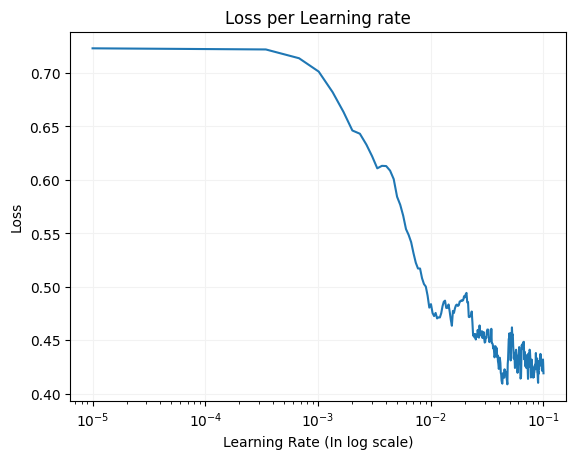

In [23]:
min_lr = 1e-5
max_lr = 1e-1
m_lr = IEEEFeedForwardModel(mc, 256, 4, 1)
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, data_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 300)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [24]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=2e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4615/4615 [00:21<00:00, 214.68it/s, t_loss=0.0567, t_acc=0.979, v_loss=0.188, v_acc=0.956]     


### Test
After testing we can pretty much see that there is no change in the model performance, so for this architecture we are **good to replace the match features** with OneHot encodings.

Testing in 782 steps: 100%|██████████████████| 782/782 [00:01<00:00, 455.77it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     96566
         1.0       0.40      0.56      0.47      3434

    accuracy                           0.96    100000
   macro avg       0.69      0.77      0.72    100000
weighted avg       0.96      0.96      0.96    100000


auc score : 0.8855
ap score  : 0.4999
-----------------------------------------------------


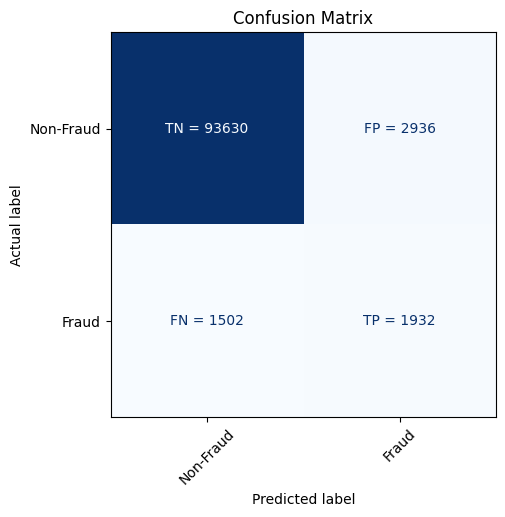

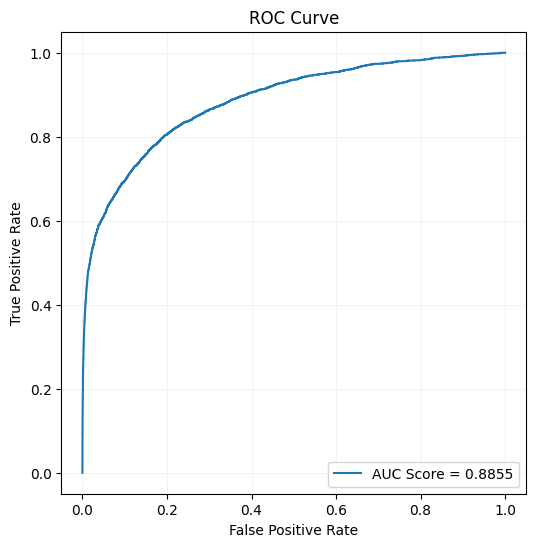

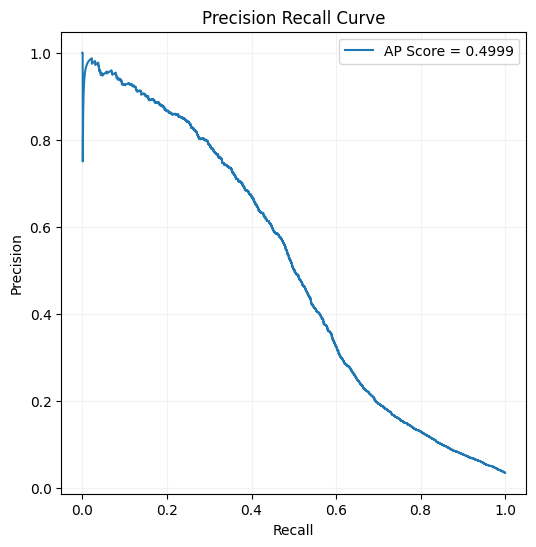

In [25]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

# Conclusion
With these tests it became clear that we can replace really low cardinality features (more or less flags) with a `FeatureOneHot` without harming the model. This does not seem to hold for feature that have slightly higher cardinality (like the product). 

Quite interesting, it seems that the embeddings might actually provide a useful abstraction in the models.